# 1 Author

**Student Name:** Felix Ambrose

**Student Number:** 210748211



# 2 Problem Formulation

The problem that I am looking to solve is to build a machine learning pipeline that takes as an input a Potter or a StarWars audio segment and predicts its song label (either Harry or StarWars).

Both songs clearly sound different, however they do have similarities making feature extraction a key area to increase accuracy of the results. This is also made harder when the dataset is both hums and whistles, as they both have different features.

# 3 Machine Learning Pipeline

Below is the machine learning pipeline:

1.   Data Input
2.   Transformation: Feature extraction and z-score normalisation
4.   Transformation: Feature Selection using a covariance matrix and an F test ('SelectKBest')
3.   Modelling using Logistic Regression and KNN and then tuning hyperparameters with 5-fold cross validation.
4.   Testing on unseen data using the candidate models.






# 4 Transformation Stage

The first step in the pipeline is transformation, namely feature extraction. Currently the files are complex with high dimensionality, so to make them more interpretable on a large scale we will extract seven features:


- Pitch standard devistion

- Pitch range

- Voiced probability - probability that a frame will be voiced

- Beats per minute (aim to capture the tempo of the song)

- Beat start: Captures the time between the first and nth beat

- Beat end: Captures the time between the nth last and last beat

- Fastest_quad: Splitting the song into 8 segments, and counting the number of beats for the fastest 2 segments. This tries to capture the beat at the fastest part of the song.

I realised that detecting a song would be less focused on certain metrics (say pitch centrality) as there are both hums and whistles for each song, however range a standard deviation of the pitch would privide some context. The main metrics would be around tempo and beat, so I studied the librosa documentation to understand which features I could use to focus on this.

After this I would go on to select three metrics by studying scatterplots, the covariance matrix and using an F test and the 'SelectKBest' Sklearn function to identify the 4 features to use in the model.

## 5 Modelling

I will experiment with two models: 


1.   Logistic Regression
2.   KNN



# 6 Methodology

The results will be validated with k-fold cross validation (at k=5), using accuracy. At this stage I will be tuning hyperparameters. After this, I will test each model (with the optimum hyperparameters) on an unseen test dataset.



# 7 Dataset

Due to the size of the dataset, I will only use a subset of the data of the two songs. However, I need to make sure that the data is balanced in terms of an even split between the songs. 

In my folders I created a training / validation and test dataset. The training dataset contains 180 samples for each song (360 samples in total). Since there were more hums than whistles in the dataset, I did not balance the interpretations as I considered that if the model were to be used with other data (or test data), it would have similar proportions.

The testing dataset contains 100 samples from each song.

**Below contains importing the data, feature extraction and feature selection**.

In [1]:
# Here we import the relevant packages and create a pth to the data.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import librosa

import IPython.display as ipd
from tqdm import tqdm

sample_path = '/Users/felixambrose/Documents/QMUL/Principles of Machine Learning/Project/Assignment 1/Training Data 2/*.wav'

files = glob.glob(sample_path)
len(files)

360

In [2]:
# Creating a list of all the samples

table = [] 

for file in files:
    file_name = file.split('/')[-1]
    participant_ID = file.split('/')[-1].split('_')[0]
    interpretation_type = file.split('/')[-1].split('_')[1]
    interpretation_number = file.split('/')[-1].split('_')[2]
    song = file.split('/')[-1].split('_')[3].split('.')[0]
    table.append([file_name,participant_ID,interpretation_type.lower(),interpretation_number, song.lower()])

In [3]:
# Making the list a pandas dataframe

df = pd.DataFrame(table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 

In [4]:
# Here we check that the dataset is balanced (song vs song)

print('The number of starwars files is: ', df.loc[df['song'] == 'starwars'].count())
print('The number of potter files is: ', df.loc[df['song'] == 'potter'].count())
print('The number of whistle files is: ', df.loc[df['interpretation'] == 'whistle'].count())
print('The number of hum files is: ', df.loc[df['interpretation'] == 'hum'].count())

The number of starwars files is:  participant       180
interpretation    180
number            180
song              180
dtype: int64
The number of potter files is:  participant       180
interpretation    180
number            180
song              180
dtype: int64
The number of whistle files is:  participant       84
interpretation    84
number            84
song              84
dtype: int64
The number of hum files is:  participant       276
interpretation    276
number            276
song              276
dtype: int64


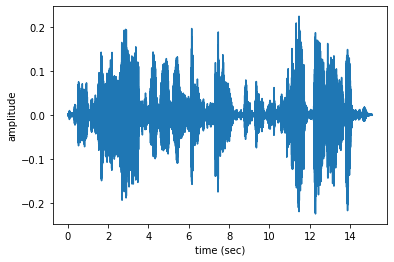

/Users/felixambrose/Documents/QMUL/Principles of Machine Learning/Project/Assignment 1/Training Data 2/S70_hum_3_StarWars.wav


In [5]:
# Here we plot a sample from the dataset, and the corresponding audio file

n= 35
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))
print(files[n])

**Feature Extraction**

In [6]:
# Here is a function for pitch, extracting two features: voiced probability and voiced flag

def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag, voiced_probs

In [7]:
# We define a function for feature extraction, and extracting the features defined in section 4.

def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        file_name = file.split('/')[-1]
        #print(file_name)
        #print(labels_file.loc[fileID]['interpretation'])
        #print(labels_file.loc[fileID]['interpretation']=='hum')
        #yi = list(labels_file.loc[fileID]['interpretation'])[0]=='hum'
        yi = labels_file.loc[fileID]['song'] == 'potter'

        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)
        
        
        if scale_audio: x = x/np.max(np.abs(x))
            
        tempo, beats = librosa.beat.beat_track(x, sr=fs)
        if len(beats) >= 8:
            beat_start = beats[7] - beats[1]    
        else:
            beat_start = 0
            
        if len(beats) >= 8:
            beat_end = beats[-1] - beats[-7]    
        else:
            beat_end = 0    
        f0, voiced_flag, voiced_probs = getPitch(x,fs,winLen=0.02)
        
        
        
        q_1 = 0
        q_2 = 0
        q_3 = 0
        q_4 = 0
        q_5 = 0
        q_6 = 0
        q_7 = 0
        q_8 = 0
        
        
        for i in range(1, len(beats)):
            if beats[i] <= (beats[-1]-beats[1])/8:
                q_1 += 1
            elif beats[i] <= 2*(beats[-1]-beats[1])/8:
                q_2 += 1
            elif beats[i] <= 3*(beats[-1]-beats[1])/8:
                q_3 += 1
            elif beats[i] <= 4*(beats[-1]-beats[1])/8:
                q_4 += 1    
            elif beats[i] <= 5*(beats[-1]-beats[1])/8:
                q_5 += 1    
            elif beats[i] <= 6*(beats[-1]-beats[1])/8:
                q_6 += 1    
            elif beats[i] <= 7*(beats[-1]-beats[1])/8:
                q_7 += 1        
            else:
                q_8 += 1
                
        
        ordered = sorted([q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8])
        fastest_quad = sum(ordered[:2])
            
        
        
        #power = np.sum(x**2)/len(x)
        #        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        #pitch_median = np.nanmedian(f0) if np.median(np.isnan(f0))<1 else 0        
        pitch_range = np.nanmax(f0) if np.max(np.isnan(f0))<1 else 0 - np.nanmin(f0) if np.min(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        #voiced_fr = np.mean(voiced_flag)
        voiced_probs = np.mean(voiced_probs)
        bpm_mean = np.mean(librosa.beat.tempo(x))

        #xi = [power,pitch_median,pitch_range,pitch_std,voiced_fr, voiced_probs, bpm_mean, beat_std]
        xi = [pitch_range,pitch_std,voiced_probs, bpm_mean, beat_start, beat_end, fastest_quad]
        #xi = [fastest_quad, beat_start, beat_end]
        X.append(xi)
        y.append(yi)

    return np.array(X),np.array(y)

In [8]:
X_raw ,y = getXy(files, labels_file=df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 360/360 [12:43<00:00,  2.12s/it]


In [9]:
# Normalise the values

mean = X_raw.mean(0)
sd =  X_raw.std(0)

X = (X_raw-mean)/sd

**Feature Selection**

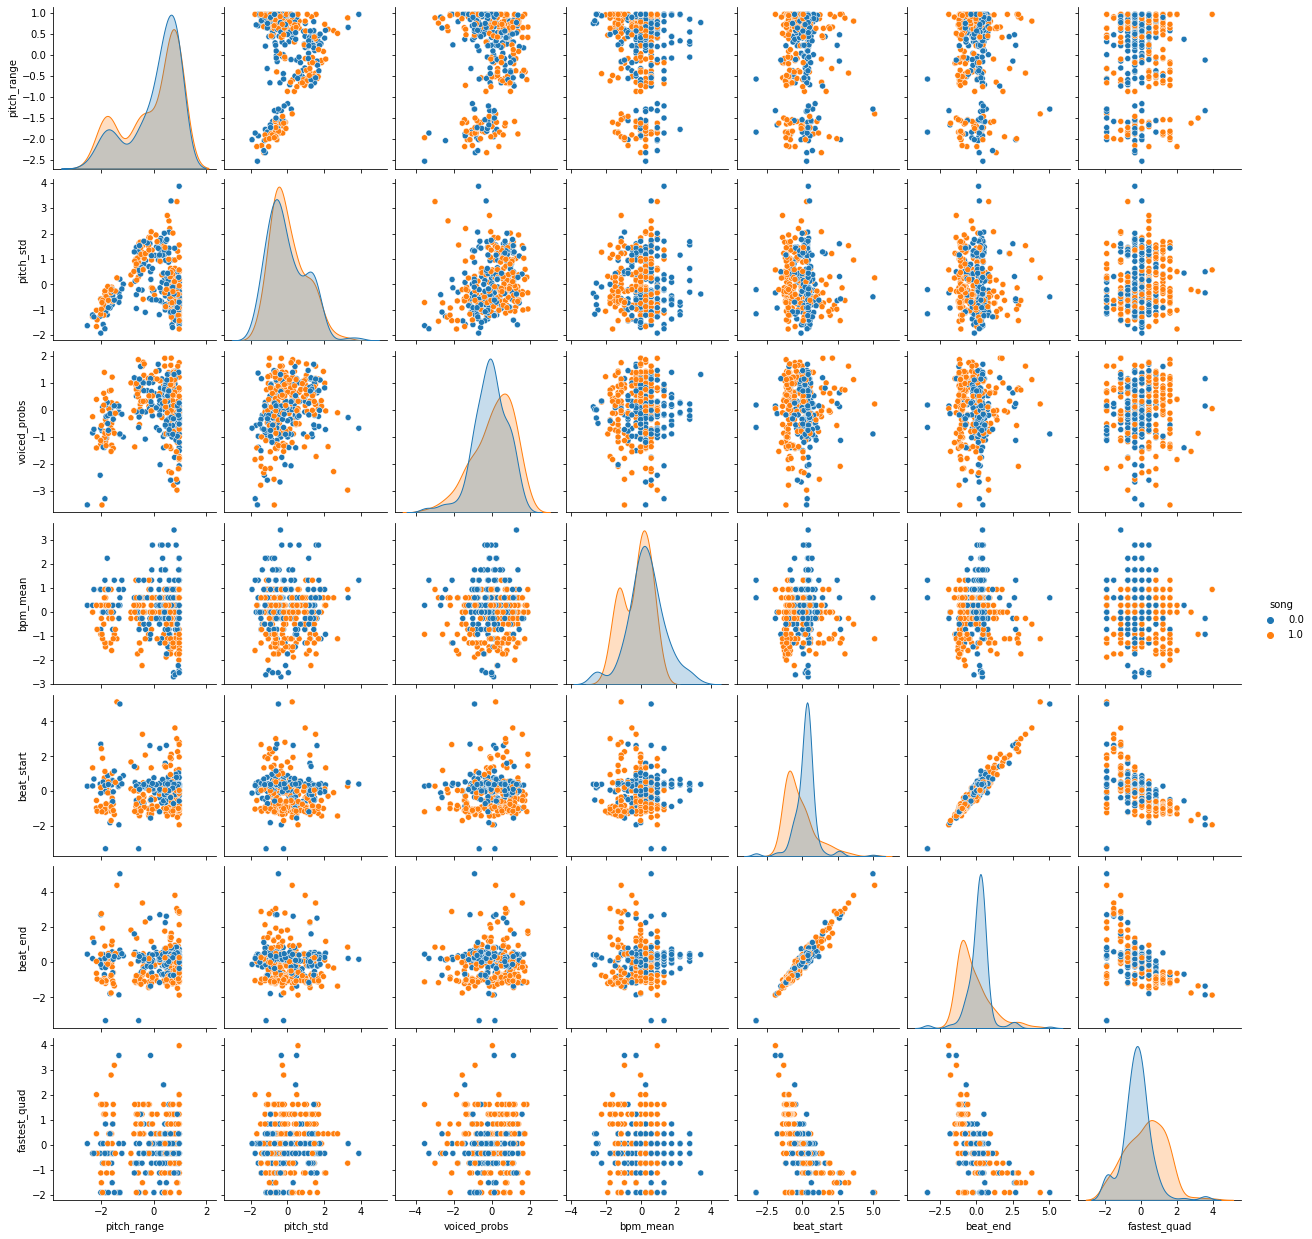

In [10]:
# Visualisation to understand the relationships between each metric and the classification song.

import seaborn as sns

X_copy = X.copy()
y_copy = y.copy()
   
all_data = []

for i in range(1, len(y_copy)):
    all_ = np.append(X_copy[i], y_copy[i])
    all_data.append(all_) 

#dataframe = pd.DataFrame(data = all_data, columns = ['pitch_range','pitch_std','voiced_probs', 'bpm_mean', 'beat_start','beat_end','song'])
dataframe = pd.DataFrame(data = all_data, columns = ['pitch_range','pitch_std','voiced_probs', 'bpm_mean','beat_start','beat_end','fastest_quad','song'])
                         
sns.pairplot(dataframe, hue ="song")

As we can see, none of the features are strongly correlated (except for the beat_start and beat_end features). Focusing on the diagonal, the 'beat' features seem to be the most different for each song. Now we will plot a covariance matrix to clarify this some more.

<AxesSubplot:>

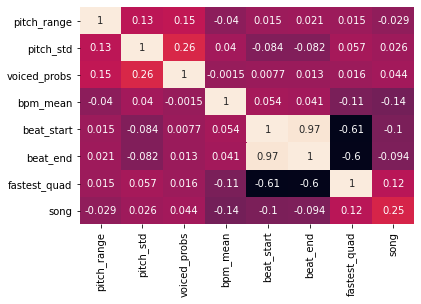

In [11]:
# Plot a covariance metrics to understand which features we can remove (those with the lowest covariance with 'song')

data_cov = dataframe.cov()
sns.heatmap(data_cov, annot = True, cbar = False)

We can see that the beat features so provide the highest covariances against 'song'. However, since the correlation between these features is higher than the others, we will carry out an F test to confim the best four features to use.

In [12]:
# Using 'SelectKBest' and the F test I could identify the best three features to use.

from sklearn.feature_selection import SelectKBest, f_classif
bestfeatures = SelectKBest(score_func=f_classif, k=4)
data_trim = bestfeatures.fit_transform(X, y)
print(bestfeatures.scores_)
print(bestfeatures.pvalues_)
print('The first row of all normalised data is: ')
print(X[0])
print('The first row of the selected normalised data is: ')
print(data_trim[0])

[ 1.10840077  0.99010713  2.79374452 29.48996982 16.6961223  13.54984909
 23.81051657]
[2.93139918e-01 3.20388260e-01 9.55066781e-02 1.03954598e-07
 5.41839158e-05 2.68078834e-04 1.60312678e-06]
The first row of all normalised data is: 
[ 0.83625368  0.46476219  0.22544839 -1.47134513 -1.11317629 -1.14209026
  1.22462956]
The first row of the selected normalised data is: 
[-1.47134513 -1.11317629 -1.14209026  1.22462956]


In [13]:
# Chosen Feature Data

X_fs = data_trim 

# 8 Results

In [14]:
# Import the relevant packages

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import statistics as st
from sklearn.linear_model import LogisticRegression

First we compute the validation accuracy for Logistic Regression after 5 fold cross validation. After carrying out some experimentation, the hyperparameters with the highest accuracy are shown below.

In [15]:
log = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
log.fit(X_fs, y)
cvlog = KFold(n_splits=5, random_state=1, shuffle=True)        
scores = cross_val_score(log, X_fs, y, scoring='accuracy', cv=cvlog, n_jobs=-1)
accuracy = sum(scores)/len(scores)
print("The mean validation accuracy is: " , accuracy)

The mean validation accuracy is:  0.65


Now we train and validate the KNN approach. Below shows the validation accuracy for different values of K. 

The validation accuracy for k= 1 is  0.7611111111111111
The validation accuracy for k= 2 is  0.7583333333333333
The validation accuracy for k= 3 is  0.7916666666666666
The validation accuracy for k= 4 is  0.7611111111111111
The validation accuracy for k= 5 is  0.7861111111111112
The validation accuracy for k= 6 is  0.7555555555555555
The validation accuracy for k= 7 is  0.7583333333333332
The validation accuracy for k= 8 is  0.7638888888888888
The validation accuracy for k= 9 is  0.7722222222222224
The validation accuracy for k= 10 is  0.7722222222222223
The validation accuracy for k= 11 is  0.7611111111111111
The validation accuracy for k= 12 is  0.763888888888889
The validation accuracy for k= 13 is  0.7527777777777777
The validation accuracy for k= 14 is  0.7416666666666666
The validation accuracy for k= 15 is  0.7527777777777778
The validation accuracy for k= 16 is  0.7388888888888888
The validation accuracy for k= 17 is  0.7416666666666666
The validation accuracy for k= 18 is  0.7

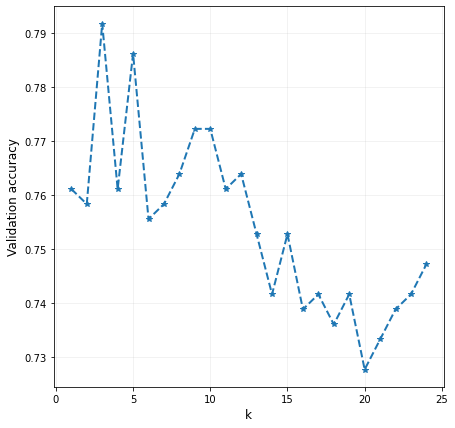

In [16]:
from sklearn import neighbors
k_values = range(1,25,1)

accuracy = dict.fromkeys(k_values)
stdev = dict.fromkeys(k_values)

for k in k_values:        
    # First we create the kNN model
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_fs,y)
    
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
        
    y_train = knn.predict(X_fs)
    y_pred = knn.predict(X_fs)
    scores = cross_val_score(knn, X_fs, y, scoring='accuracy', cv=cv, n_jobs=-1)
    accuracy[k] = np.sum(scores)/len(scores)
    stdev[k] = st.stdev(scores)
    
    print("The validation accuracy for k=", k, "is ", accuracy[k])
    #print("The validation stdev for k=", k, "is ", stdev[k])


# Here we predict the value of the validation accuracy as a function of k
plt.figure(figsize=(7, 7))
plt.plot(k_values, list(accuracy.values()), '--*', linewidth=2)
plt.xlabel("k", fontsize=12)
plt.ylabel("Validation accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.show() 

We can see that the k = 3 provides the highest validation accuracy, and so I will use this hyperparameters in the testing phase.

**We will now import test data to test the optimum models.**


In [17]:
sample_path = '/Users/felixambrose/Documents/QMUL/Principles of Machine Learning/Project/Assignment 1/Test Data 2/*.wav'

test_files = glob.glob(sample_path)
len(test_files)

200

In [18]:
test_table = [] 

for file in test_files:
    file_name = file.split('/')[-1]
    participant_ID = file.split('/')[-1].split('_')[0]
    interpretation_type = file.split('/')[-1].split('_')[1]
    interpretation_number = file.split('/')[-1].split('_')[2]
    song = file.split('/')[-1].split('_')[3].split('.')[0]
    test_table.append([file_name,participant_ID,interpretation_type.lower(),interpretation_number, song.lower()])

In [19]:
test_df = pd.DataFrame(test_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 

In [20]:
X_raw_test ,y_test = getXy(test_files, labels_file=test_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 200/200 [07:13<00:00,  2.17s/it]


In [21]:
# Normalise the Values

mean_test = X_raw_test.mean(0)
sd_test =  X_raw_test.std(0)

X_test = (X_raw_test-mean_test)/sd_test

X_fs_test = X_test[:,[3,4,5,6]]

In [22]:
# Test with Logistic Regression

log = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
log.fit(X_fs, y)
y_pred = log.predict(X_fs_test)
accuracy = sum(y_pred == y_test)/len(y_pred)
print("The test accuracy is: " , accuracy)

The test accuracy is:  0.655


In [23]:
# Test with the KNN model at k = 3

n = 3

knn = neighbors.KNeighborsClassifier(n_neighbors=n)
knn.fit(X_fs,y)
y_pred = knn.predict(X_fs_test)
accuracy = np.sum(y_pred == y_test)/len(y_test)
#stdev = st.stdev(scores)
#print('Accuracy: %.3f (%.3f)' % (sum(scores)/len(scores), st.stdev(scores)))
    
print("The test accuracy for k=", n, "is ", accuracy)

The test accuracy for k= 3 is  0.745


# 9 Conclusion



From the results we can see that the KNN approach performs the strongest with the validation and test dataset. The test performance itself is random so this approach could appear superior by chance, or if the participants in the test dataset had less ambiguous recordings than training. An improvement could be made to increase the randomness in the way that the training and test dataset are organised, so it is not dependent on the participant number.

Since 50% is random for the result of this binary classifier, 74.5% clearly shows the impact of the model however more training data would increase the accuracy further. Also, more improvements could be made with the features. We could see that none of the features had a very strong covariance relationship with the song. Beats per minute and 'fastest_quad' had the strongest, so I would like to take more time to understand features that can extract more tempo and melody characteristics. 
